# Lagged Predictions of Next Week Alcohol Use for Precision Mental

Health Support

Kendra Wyant (Department of Psychology, University of Wisconsin-Madison)  
Gaylen E. Fronk (Department of Psychology, University of Wisconsin-Madison)  
Jiachen Yu (Department of Psychology, University of Wisconsin-Madison)  
John J. Curtin (Department of Psychology, University of Wisconsin-Madison)  
December 4, 2024

We evaluated the performance of a model predicting immediate alcohol lapses and models with increasing lag time between the prediction time points and start of the prediction window (24, 72, 168, or 336 hour lag). Model features were engineered from 4x daily ecological momentary assessment. Participants (N =151; 51% male; mean age= 41; 87% White, 97% Non-Hispanic) were in early recovery from alcohol use disorder and provided data for up to three months. We used nested cross-validation to select and evaluate the best models. Median auROCs were high across models (range = 0.85 – 0.89). All lagged models performed worse than the 0 lag model (probabilities \> .95). All models performed worse for disadvantaged groups (not White vs. non-Hispanic White, below poverty vs. above poverty, female vs. male).

In [ ]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))

path_models_lag <- format_path(str_c("studydata/risk/models/lag"))
path_processed <- format_path("studydata/risk/data_processed/lag")

options(knitr.kable.NA = '')

In [ ]:
# read in tibbles for in-line code

test_metrics_all_pp_perf <- read_csv(here::here(path_models_lag, "test_metrics_all_pp_perf.csv"), 
                                     col_types = cols())

ci_baseline <- read_csv(here::here(path_models_lag, "ci_baseline.csv"), 
                        col_types = cols())

ci_lag <- read_csv(here::here(path_models_lag, "ci_lag.csv"), col_types = cols())

pp_dem <- read_csv(here::here(path_models_lag, "pp_dem_all.csv"), col_types = cols())

pp_dem_contrast <- read_csv(here::here(path_models_lag, "pp_dem_contrast_all.csv"), col_types = cols())

screen <- read_csv(here::here(path_processed, "dem_tibble.csv"),
                   col_types = cols())

lapses_per_subid <- read_csv(here::here(path_processed, "lapse_tibble.csv"),
                             col_types = cols())

# Introduction

## Precision Medicine

Substance use disorders are chronic diseases, characterized by high relapse rates, frequent reentry into treatment, and an increased risk of mortality \[@dennisManagingAddictionChronic2007\]. Few individuals receive any treatment, and even fewer receive continuous care throughout their recovery \[@samhsacenterforbehavioralhealthstatisticsandquality2021NSDUHDetailed2021\]. Continuing care, including ongoing monitoring and early re-intervention, has been well established as the gold standard for managing chronic health conditions such as diabetes, asthma, and HIV. Yet, continuing care for substance use disorders is largely lacking \[@stanojlovicTargetingBarriersSubstance2021; @sociasAdoptingCascadeCare2016\].

Importantly, people need different types of support at different points in their recovery. Personalized monitoring of changes in relapse risk factors could help patients adapt their lifestyle, behaviors, and supports to successfully address these factors \[@kranzlerPersonalizedTreatmentAlcohol2012; @friedmannEffectMatchingComprehensive2004\]. A precision medicine approach to automated continuous relapse risk monitoring and recovery support could help fill this gap in continuing care.

Precision medicine has been a goal in healthcare for over half a century \[@derubeisHistoryCurrentStatus2019\]. Traditionally, it seeks to answer the question of *how* to best treat a specific individual, given their unique combination of genetic, lifestyle, and environmental characteristics (e.g., which medication is most effective for whom).

Today, this approach extends to mental health conditions (i.e., precision mental health) such as depression, substance use disorders, and suicide. Mental health conditions are complex, fluctuating processes. Many medical conditions often have clear biological precursors, that can be treated well with a single medication. In contrast, mental health conditions are influenced by numerous psychosocial factors, and require a wide array of support options. Moreover, the factors driving mental health conditions differ between individuals and can change within an individual over time. Thus, precision mental health must consider both the *how* and the *when* (e.g., which treatment is most effective for whom at what moment).

## Previous Work

In early example of precision mental health applied to substance use disorders, the Project MATCH research group attempted to match individuals with alcohol use disorder to their optimal treatment based on baseline measures of individual characteristics \[@projectmatchresearchgroupMatchingAlcoholismTreatments1997\]. Unfortunately, early studies like these were methodologically constrained to use small sets of features (i.e., individual trait and demographic differences) that failed to capture the complex and heterogeneous nature of substance use disorders and use a single measurement point (i.e., at baseline) to predict a non-linear, time-varying course of recovery, lapse, and relapse \[@witkiewitzModelingComplexityPosttreatment2007\].

Recent advances in both machine learning and personal sensing may address these barriers to successful precision mental health. Machine learning can handle large sets of features and non-linear and interactive relationships between these features. As a result models better represent the nuanced complexity of mental health conditions. Moreover, machine learning tools can help understand which factors are important to a specific individual at a specific moment in time, addressing the question of *how*.

Personal sensing allows for frequent, longitudinal measurement of changes in proximal risk (e.g., for a lapse) with high temporal precision, for better understanding the *when*. This precision is particularly important for predicting discrete symptoms or behaviors. It would be unreasonable to expect that we could predict a lapse with any temporal precision using only demographic and baseline characteristics that become more distal as time progresses. Rather, lapse prediction requires dense, long-term monitoring of symptoms and related states proximal to the outcome. Ecological momentary assessment (EMA) may be particularly well-suited for risk prediction algorithms. It offers momentary subjective insight into constructs that can be easily mapped onto modular forms of treatment, such as the relapse prevention model \[@marlattRelapsePreventionMaintenance1985; @witkiewitzRelapsePreventionAlcohol2004\]. EMA also appears to be well tolerated by individuals with substance use disorders \[@wyantAcceptabilityPersonalSensing2023; @moshontzProspectivePredictionLapses2021\]. Thus, it can serve as an important signal for predicting substance use outcomes and interpreting clinically relevant features over a sustained period.

Promising preliminary work suggests it is possible to build EMA models that predict immediate lapses back to substance use \[@waltersUsingMachineLearning2021; @baeMobilePhoneSensors2018; @soysterPooledPersonspecificMachine2022; @chihPredictiveModelingAddiction2014\]. In a previous study from our group, we demonstrated that we can do this very well \[@wyantMachineLearningModels2023\]. We used 4X daily EMA with questions designed to measure theoretically-implicated risk factors including past use, craving, past pleasant events, past and future risky situations, past and future stressful events, emotional valence and arousal, and self-efficacy. We used all available data up until a moment in time to predict the probability of an alcohol lapse in the next week, day, and hour.

Narrow prediction window widths (i.e., next hour or next day) are well suited for addressing immediate risk. These models can be dynamically updated (i.e., at least daily) to provide individuals information about changes in their risk and make supportive recommendations based on the top features contributing to their risk. For example, recommending a coping with craving activity when someone has increased craving, or recommending a guided relaxation video when someone is reporting recent stressful events. Importantly, this assumes that the recommendations can be implemented immediately.

However, many appropriate support recommendations take time to set up, and are not available in the moment (e.g., attending a self-help meeting, planning an outing with important people in their life, or scheduling an appointment with a therapist). In these cases, patients would benefit from advanced warning about changes in their risk.

While our next week model may be less helpful for addressing immediate risk, as a lapse can occur at any point in the week window (i.e., immediately up until one week from now). It may be preferred for as a *time-lagged* model where prediction windows are shifted further into the future (i.e., away from the moment in time the model is updated) to provide patients with increased lead time to implement supports not immediately available to them. A wider prediction window width (i.e, one week) will yield higher proportions of positive labels mitigating issues of an unbalanced outcome. Additionally, when scheduling real world support, it is important that the lead up time is adequate and not that the prediction is necessarily temporally precise.

## Current Study

In this study, we evaluated the performance of a model predicting immediate next week lapses compared to models using increased lag time between the prediction time points and the start of the prediction window. Specifically, we used the same EMA features as our immediate model and trained new models to predict the probability of a lapse beginning one day (24 hours), three days (72 hours), one week (168 hours), or two weeks (336 hours) into the future. We evaluated each lagged model to determine if they perform at clinically implementable levels and assessed the relative difference in performance as lag time increased.

It is also important to look beyond overall model performance. Models that work for only a subset of people, if implemented, could widen existing treatment disparities. Therefore we reported our models’ performance for three dichotomized demographic groups with known disparities in access to substance use treatment - race and ethnicity (not White vs. non-Hispanic White) \[@pinedoCurrentReexaminationRacial2019; @kilaruIncidenceTreatmentOpioid2020\], income (below poverty vs. above poverty) \[@olfsonHealthcareCoverageService2022\], and sex at birth (female vs. male) \[@greenfieldSubstanceAbuseTreatment2007; @kilaruIncidenceTreatmentOpioid2020\].

# Methods

## Transparency and Openness

We adhere to research transparency principles that are crucial for robust and replicable science. We preregistered our data analytic strategy. We reported how we determined the sample size, all data exclusions, all manipulations, and all study measures. We provide a transparency report in the supplement. Finally, our data, analysis scripts, annotated results, questionnaires, and other study materials are publicly available (<https://osf.io/xta67/>).

## Participants

We recruited participants in early recovery (1-8 weeks of abstinence) from moderate to severe alcohol use disorder in Madison, Wisconsin, US for a three month longitudinal study. One hundred fifty one participants were included in our analyses. We used data from all participants included in our previous study (see \[@wyantMachineLearningModels2023\] for enrollment and disposition information). This sample size was determined based on traditional power analysis methods for logistic regression \[@hsiehSampleSizeTables1989\] because comparable approaches for machine learning models have not yet been validated. Participants were recruited through print and targeted digital advertisements and partnerships with treatment centers. We required that participants:

1.  were age 18 or older,
2.  could write and read in English,
3.  had at least moderate AUD (\>= 4 self-reported DSM-5 symptoms),
4.  were abstinent from alcohol for 1-8 weeks, and
5.  were willing to use a single smartphone (personal or study provided) while on study.

We also excluded participants exhibiting severe symptoms of psychosis or paranoia.

## Procedure

Participants completed five study visits over approximately three months. After an initial phone screen, participants attended an in-person screening visit to determine eligibility, complete informed consent, and collect self-report measures. Eligible, consented participants returned approximately one week later for an intake visit. Three additional follow-up visits occurred about every 30 days that participants remained on study. Participants were expected to complete four daily EMAs while on study. Other personal sensing data streams (geolocation, cellular communications, sleep quality, and audio check-ins) were collected as part of the parent grant’s aims (R01 AA024391). Participants could earn up to \$150/month if they completed all study visits, had 10% or less missing EMA data and opted in to provide data for other personal sensing data streams.

## Measures

### Ecological Momentary Assessments

Participants completed four brief (7-10 questions) EMAs daily. The first and last EMAs of the day were scheduled within one hour of participants’ typical wake and sleep times. The other two EMAs were scheduled randomly within the first and second halves of their typical day, with at least one hour between EMAs. Participants learned how to complete the EMA and the meaning of each question during their intake visit.

On all EMAs, participants reported dates/times of any unreported past alcohol use. Next, participants rated the maximum intensity of recent (i.e., since last EMA) experiences of craving, risky situations, stressful events, and pleasant events. Finally, participants rated their current affect on two bipolar scales: valence (Unpleasant/Unhappy to Pleasant/Happy) and arousal (Calm/Sleepy to Aroused/Alert).

On the first EMA each day, participants also rated the likelihood of encountering risky situations and stressful events in the next week and the likelihood that they would drink alcohol in the next week (i.e., abstinence self-efficacy).

### Individual Characteristics

We collected self-report information about demographics (age, sex, race, ethnicity, education, marital status, employment, and income) and AUD symptom count to characterize our sample. Demographic information was also included as features in our models and a subset (sex, race, ethnicity, and income) used for model fairness analyses.

As part of the aims of the parent project we collected many other trait and state measures throughout the study. A complete list of all measures can be found on our study’s OSF page.

## Data Analytic Strategy

Data preprocessing, modeling, and Bayesian analyses were done in R using the tidymodels ecosystem \[@kuhnTidymodelsCollectionPackages2020; @kuhnTidyposteriorBayesianAnalysis2022; @goodrichRstanarmBayesianApplied2023\]. Models were trained and evaluated using high-throughput computing resources provided by the University of Wisconsin Center for High Throughput Computing \[@chtc\].

### Predictions

A *prediction time point* is the hour at which our model calculated a predicted probability of a lapse. All available data up until, but not including, the prediction time point was used to generate these predictions. Prediction time points were updated hourly (@fig-methods, Panel A). The first prediction time point for each participant was 24 hours from midnight on their study start date. This ensured at least 24 hours of past EMAs for future lapse prediction at these first time points. Subsequent prediction time points for each participant repeatedly rolled hour-by-hour until the end of their study participation.

The *prediction window* is the window of time in which a lapse might occur. The prediction window width for all our models was one week (i.e., models predicted the probability of a lapse occurring within a one week window). Prediction windows rolled forward hour-by-hour with the prediction time point (@fig-methods, Panel B).

Finally, there were five possible *lag times* between the prediction time point and start of the prediction window. A prediction window either started immediately after the prediction time point (0 lag) or was lagged by 24, 72, 168, or 336 hours (@fig-methods, Panel B).

Therefore, our models provided hour-by-hour probabilities of an alcohol lapse in the next week pushed out up to two weeks into the future.

``` python
knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)
```

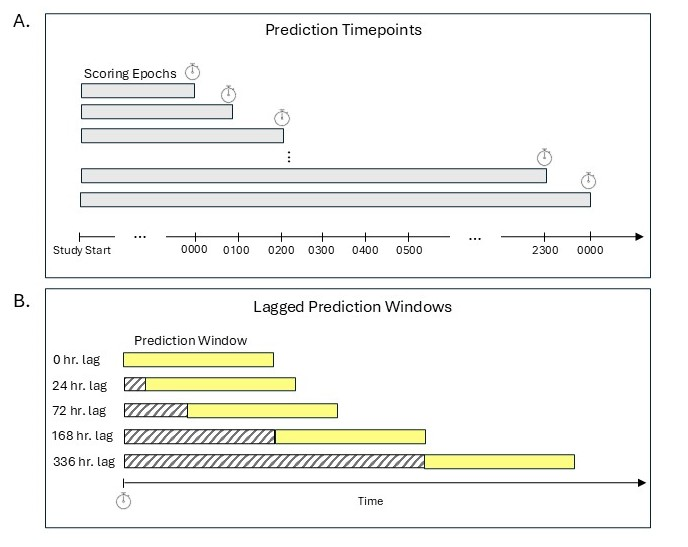

### Labels

The start and end date/time of past drinking episodes were reported on the first EMA item. A prediction window was labeled *lapse* if the start date/hour of any drinking episode fell within that window. A window was labeled *no lapse* if no alcohol use occurred within that window +/- 24 hours. If no alcohol use occurred within the window but did occur within 24 hours of the start or end of the window, the window was excluded.

We ended up with a total of 270,081 labels for our baseline (no lag) model, 266,599 labels for our 24 hour lagged model, 259,643 labels for our 72 hour lagged model, 245,707 labels for our 168 hour lagged model, and 221,206 labels for our 336 hour lagged model.

### Feature Engineering

Features were calculated using only data collected before the start of each prediction time point to ensure our models were making true future predictions. For our no lag models this included all data prior to the hour of the start of the prediction window. For our lagged models, the last EMA data used for feature engineering were collected up to 24 hours, 72 hours, 168 hours, or 336 hours prior to the start of the prediction window.

A total of 279 features were derived from two data sources:

1.  *Demographics*: We created quantitative features for age and personal income, and dummy-coded features for sex, race/ethnicity, marital status, education, and employment.

2.  *Previous EMA responses*: We created raw EMA and change features for varying scoring epochs (i.e., 12, 24, 48, 72, and 168 hours) before the prediction time point for all EMA items. Raw features included min, max, and median scores for each EMA item across all EMAs in each epoch for that participant. We calculated change features by subtracting the participants’ overall mean score for each EMA item (using all EMAs collected before the start of the prediction window) from the associated raw feature. We also created raw and change features based on the most recent response for each EMA question and raw and change rate features from previously reported lapses and number of completed EMAs.

Other generic feature engineering steps included imputing missing data (median imputation for numeric features, mode imputation for nominal features) and removing zero and near-zero variance features as determined from held-in data (see Cross-validation section below).

### Model Training and Evaluation

#### Model Configurations

We trained and evaluated five separate classification models: one baseline (no lag) model and one model for 24 hour, 72 hour, 168 hour, and 336 hour lagged predictions. We considered four well-established statistical algorithms (elastic net, XGBoost, regularized discriminant analysis, and single layer neural networks) that vary across characteristics expected to affect model performance (e.g., flexibility, complexity, handling higher-order interactions natively) \[@kuhnAppliedPredictiveModeling2018\].

Candidate model configurations differed across sensible values for key hyperparameters. They also differed on outcome resampling method (i.e., no resampling and up-sampling and down-sampling of the outcome using majority/no lapse to minority/lapse ratios ranging from 1:1 to 2:1). We calibrated predicted probabilities using the beta distribution to support optimal decision-making under variable outcome distributions \[@kullSigmoidsHowObtain2017\].

#### Cross-validation

We used participant-grouped, nested cross-validation for model training, selection, and evaluation with auROC. auROC indexes the probability that the model will predict a higher score for a randomly selected positive case (lapse) relative to a randomly selected negative case (no lapse). Grouped cross-validation assigns all data from a participant as either held-in or held-out to avoid bias introduced when predicting a participant’s data from their own data. We used 1 repeat of 10-fold cross-validation for the inner loops (i.e., *validation* sets) and 3 repeats of 10-fold cross-validation for the outer loop (i.e., *test* sets). Best model configurations were selected using median auROC across the 10 validation sets. Final performance evaluation of those best model configurations used median auROC across the 30 test sets.

#### Bayesian Model

We used a Bayesian hierarchical generalized linear model to estimate the posterior probability distributions and 95% Bayesian credible intervals (CIs) from the 30 held-out test sets for our five best models. Following recommendations from the rstanarm team and others \[@rstudioteamRStudioIntegratedDevelopment2020; @gabryPriorDistributionsRstanarm2023\], we used the rstanarm default autoscaled, weakly informative, data-dependent priors that take into account the order of magnitude of the variables to provide some regularization to stabilize computation and avoid over-fitting.[1] We set two random intercepts to account for our resampling method: one for the repeat, and another for the fold nested within repeat. We specified two sets of contrasts for model comparisons. The first set compared each lagged model to the baseline model (0 lag vs. 24 hour lag, 0 lag vs. 72 hour lag, 0 lag vs. 168 lag, 0 lag vs. 336 lag). The second set compared adjacently lagged models (24 hour lag vs. 72 hour lag, 72 hour lag vs. 168 hour lag, 168 hour lag vs. 336 hour lag). auROCs were transformed using the logit function and regressed as a function of model contrast.

From the Bayesian model we obtained the posterior distribution (transformed back from logit) and Bayeisan CIs for all five models. To evaluate our models’ overall performance we report the median posterior probability for auROC and Bayesian CIs. This represents our best estimate for the magnitude of the auROC parameter for each model. If the confidence intervals do not contain .5 (chance performance), this suggests our model is capturing signal in the data.

We then conducted Bayesian model comparisons using our two sets of contrasts - baseline and adjacent lags. For both model comparisons, we determined the probability that the models’ performances differed systematically from each other. We also report the precise posterior probability for the difference in auROCs and the 95% Bayesian CIs. If there was a probability \>.95 that the more lagged model’s performance was worse, we labeled the model contrast as significant.

#### Fairness Analyses

We calculated the median posterior probability and 95% Bayesian CI for auROC for each model separately by race and ethnicity (not White vs. non-Hispanic White), income (below poverty vs. above poverty[2]), and sex at birth (female vs. male). We conducted Bayesian group comparisons to assess the likelihood that each model performs differently by group. We report the median difference and range in posterior probabilities across all models. The median auROC and Bayesian CIs are reported separately by group and model in the supplement.[3]

# Results

## Demographic and Lapse Characteristics

\[@tbl-demohtml\] provides a detailed breakdown of the demographic and lapse characteristics of our sample (N = 151).

``` python
table_dem |> 
  knitr::kable()
```

  ---------------------------------------------------------------------------------
  var                                  N     \% M          SD         Range
  -------------------------------- ----- ------ ---------- ---------- -------------
  Age                                           41         11.9       21-72

  Sex                                                                 

  Female                              74   49.0                       

  Male                                77   51.0                       

  Race                                                                

  American Indian/Alaska Native        3    2.0                       

  Asian                                2    1.3                       

  Black/African American               8    5.3                       

  White/Caucasian                    131   86.8                       

  Other/Multiracial                    7    4.6                       

  Hispanic, Latino, or Spanish                                        
  origin                                                              

  Yes                                  4    2.6                       

  No                                 147   97.4                       

  Education                                                           

  Less than high school or GED         1    0.7                       
  degree                                                              

  High school or GED                  14    9.3                       

  Some college                        41   27.2                       

  2-Year degree                       14    9.3                       

  College degree                      58   38.4                       

  Advanced degree                     23   15.2                       

  Employment                                                          

  Employed full-time                  72   47.7                       

  Employed part-time                  26   17.2                       

  Full-time student                    7    4.6                       

  Homemaker                            1    0.7                       

  Disabled                             7    4.6                       

  Retired                              8    5.3                       

  Unemployed                          18   11.9                       

  Temporarily laid off, sick           3    2.0                       
  leave, or maternity leave                                           

  Other, not otherwise specified       9    6.0                       

  Personal Income                               \$34,298   \$31,807   \$0-200,000

  Marital Status                                                      

  Never married                       67   44.4                       

  Married                             32   21.2                       

  Divorced                            45   29.8                       

  Separated                            5    3.3                       

  Widowed                              2    1.3                       

  DSM-5 AUD Symptom Count                       8.9        1.9        4-11

  Reported 1 or More Lapse During                                     
  Study Period                                                        

  Yes                                 84   55.6                       

  No                                  67   44.4                       

  Number of reported lapses                     6.8        12         0-75
  ---------------------------------------------------------------------------------

## Model Evaluation

Histograms of the full posterior probability distributions for auROC for each model are available in the supplement. The median auROCs from these posterior distributions were 0.892 (baseline), 0.886 (24 hour lag), 0.874 (72 hour lag), 0.869 (168 hour lag), and 0.851 (336 hour lag). These values represent our best estimates for the magnitude of the auROC parameter for each model. The 95% Bayesian CI for the auROCs for these models were relatively narrow and did not contain 0.5: baseline \[0.872-0.910\], 24 hour lag \[0.865-0.905\], 72 hour lag \[0.851-0.894\], 168 hour lag \[0.846-0.891\], 336 hour lag \[0.825-0.874\]. Panel A in @fig-1 displays these median auROCs and 95% Bayesian CIs by model. A description of feature importance by model is available in the supplement.

``` python
fig_1
```

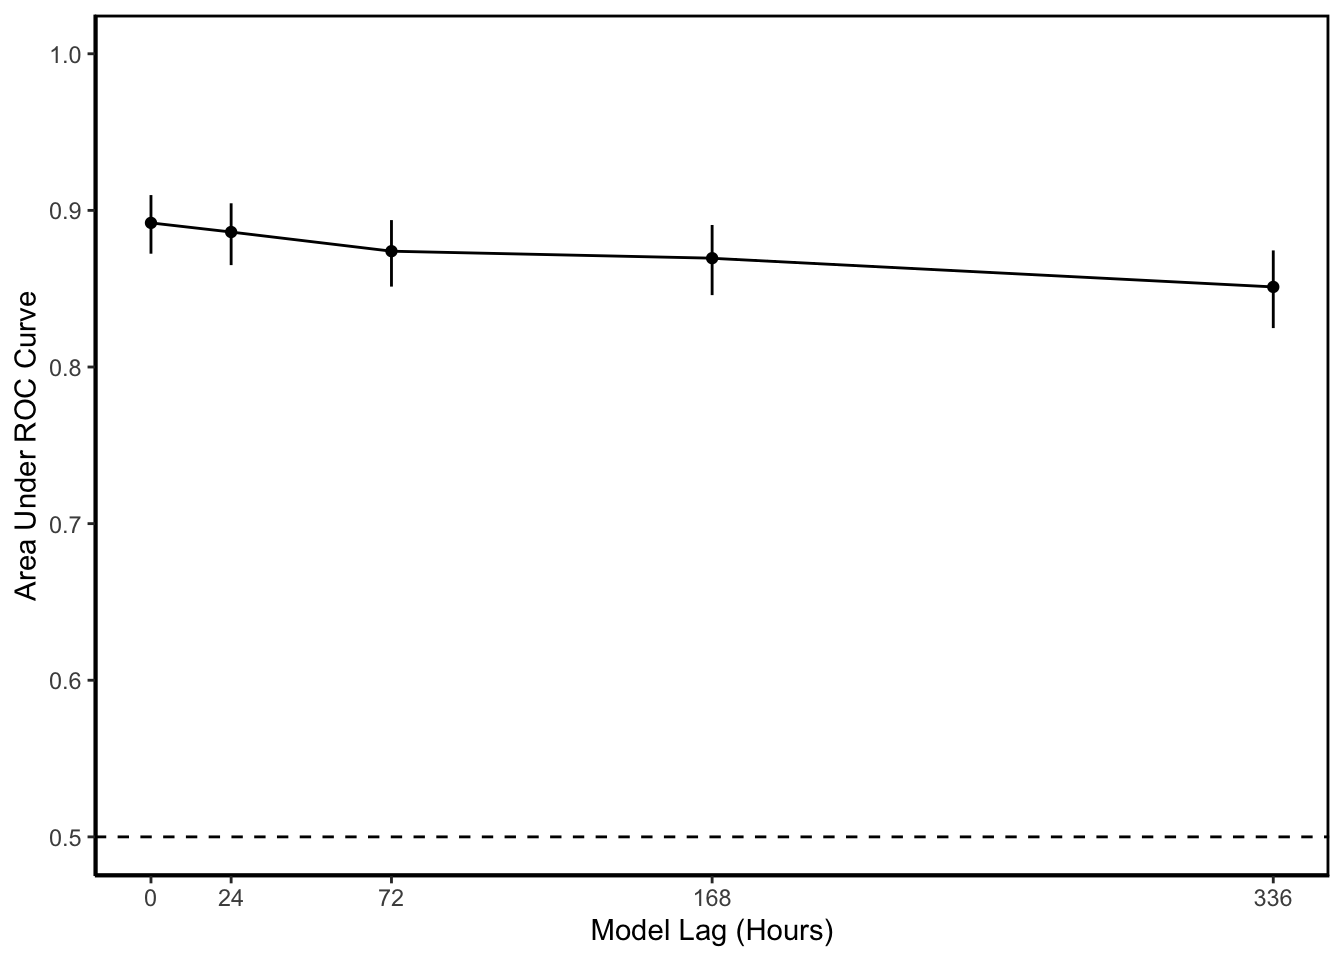

## Model Comparisons

### Baseline Contrasts

The median decrease in auROC for the baseline vs. 24 hour lag model was 0.006 (95% CI=\[0.000-0.012\]), yielding a significant probability of 0.956 that the lagged model had worse performance. The median decrease in auROC for the baseline vs. 72 hour model was 0.018 (95% CI=\[0.012-0.025\]), yielding a significant probability of 1.000 that the lagged model had worse performance. The median decrease in auROC for the baseline vs. 168 hour lag model was 0.023 (95% CI=\[0.016-0.029\]), yielding a significant probability of 1.000 that the lagged model had worse performance. The median decrease in auROC for the baseline vs. 336 hour lag model was 0.041 (95% CI=\[0.033-0.050\]), yielding a significant probability of 1.000 that the lagged model had worse performance.

### Adjacent Contrasts

The median decrease in auROC for the 24 hour vs. 72 hour lag model was 0.012 (95% CI=\[0.006-0.019\]), yielding a significant probability of 0.999 that the 72 hour lag model had worse performance than the 24 hour lag model. The median decrease in auROC for the 72 hour vs. 168 hour lag model was 0.004 (95% CI=\[-0.002-0.011\]), yielding a non-significant probability of 0.862 that the 168 hour lag model had worse performance than the 72 hour lag model. The median decrease in auROC for the 168 hour vs. 336 hour lag model was 0.018 (95% CI=\[0.011-0.026\]), yielding a significant probability of 1.000 that the 336 hour lag model had worse performance than the 168 hour lag model.

## Fairness Analyses

@fig-2 shows the median auROC and credible intervals for each model separately by race (not White; *N* = 20 vs. Non-Hispanic White; *N* = 131), sex at birth (female; *N* = 74 vs. Male; *N* = 77), and income (below poverty; *N* = 18 vs. above poverty; *N* = 133). All group comparisons were significant (probability \> .95) across models. On average there was a median decrease in auROC of 0.161 (range 0.108-0.175) for participants who were not White compared to non-Hispanic White participants. On average there was a median decrease in auROC of 0.080 (range 0.058-0.116) for female participants compared to male participants. On average there was a median decrease in auROC of 0.092 (range 0.087-0.133) for participants below the federal poverty line compared to participants above the federal poverty line.

``` python
pp_dem_a + pp_dem_b + pp_dem_c + plot_layout(guides = "collect") &
  theme(legend.position = "bottom") &
  plot_annotation(tag_levels = "A")
```

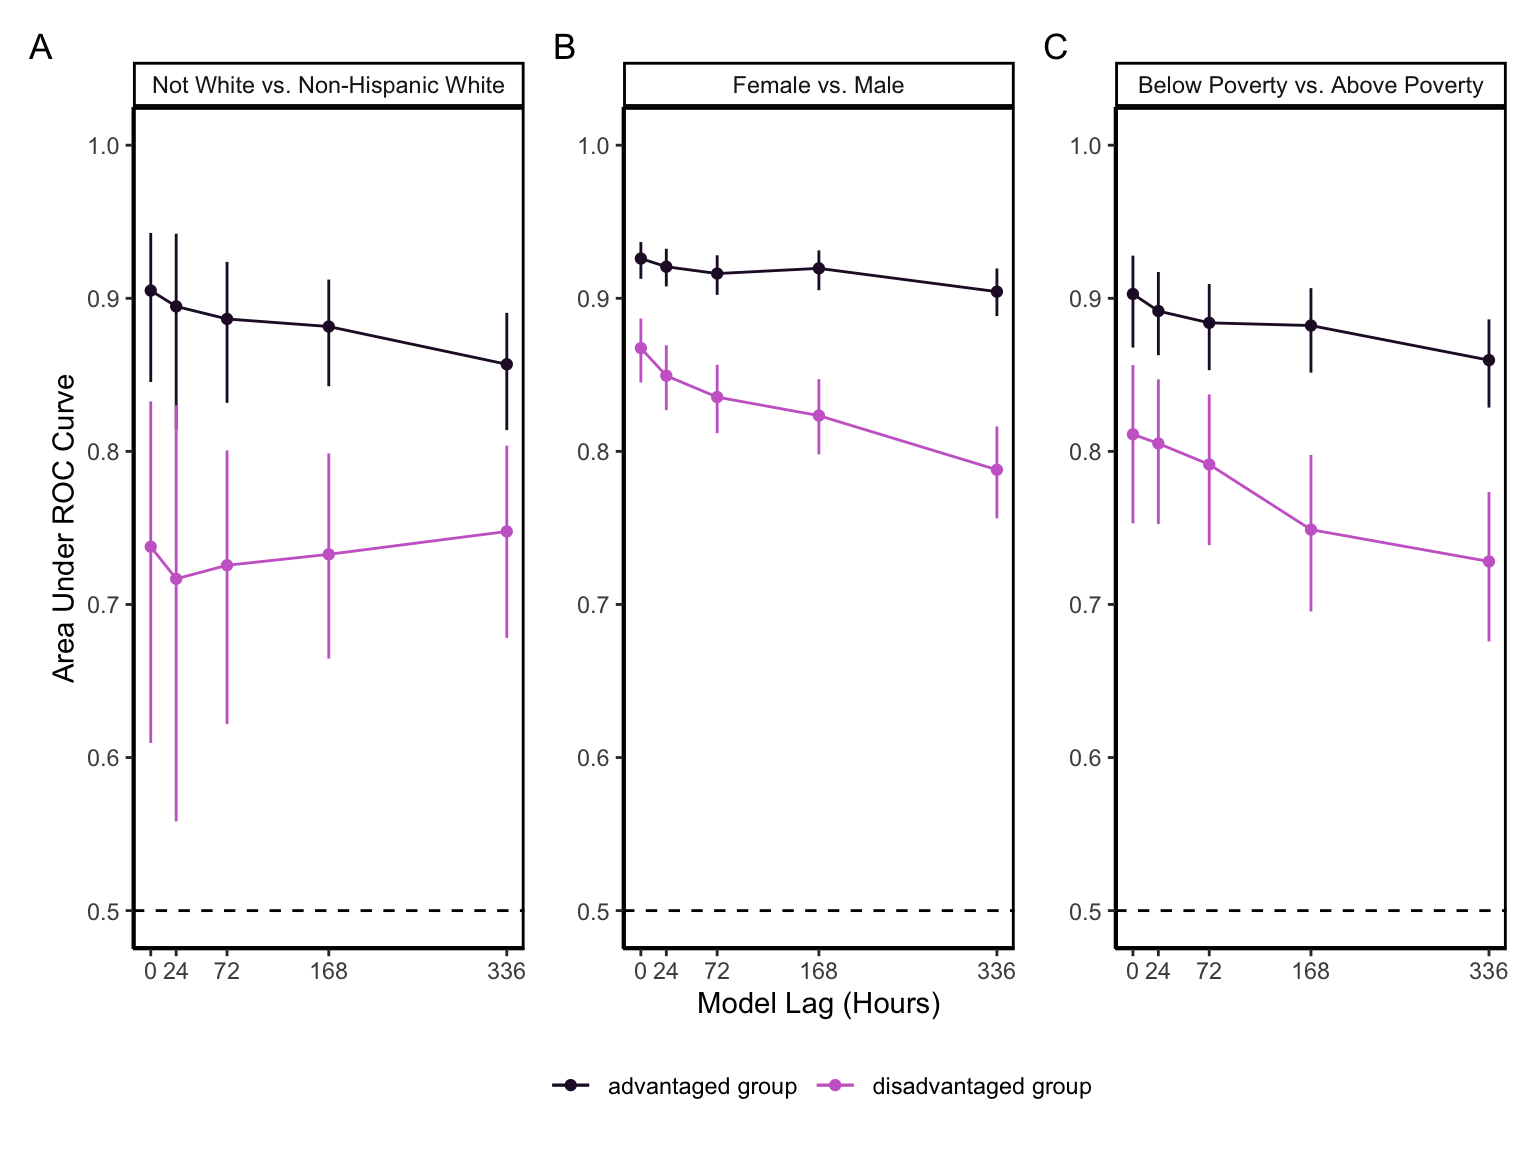

## Discussion

## Model Performance

Our models performed exceptionally well with median posterior probabilities for auROCs of .85 - .89. This suggests we can achieve clinically meaningful performance up to two weeks out. Our rigorous resampling methods (grouped, nested, k-fold cross-validation) make us confident that these are valid estimates of how our models would perform with new individuals.

Nevertheless, model performance did significantly decrease as models predicted further into the future. This is unsurprising given what we know about prediction and substance use. Many important relapse risk factors are fluctuating processes that can change day-by-day, if not more frequently. As lag time increases, features become less proximal to the prediction time point. Still, we wish to emphasize that our lowest auROC (.85) is still excellent, and the benefit of advanced notice likely outweighs the cost to performance.

## Model Fairness

All models performed worse for people who were not White, and for people who had an income below the poverty line. The largest contributing factor is likely the lack of diversity in our training data. For example, even with our coarse combination of race/ethnicity, the not White group was largely underrepresented relative to the non-Hispanic White group. The best solution to this limitation would be to recruit a more representative sample. However, there may be methods to mitigate these issues in the current data. We could explore upsampling disadvantaged group representation in the data (e.g., using synthetic minority oversampling technique). We also could adjust the penalty weights so that prediction errors for disadvantaged groups are weighted more heavily than prediction errors for majority groups. We could also consider using personalized modeling approaches that consider the characteristics and behaviors important to an individual rather than generalizing across a population. For example, state space models inherently capture time series data and allow for the modeling of how an individual’s risk evolves over time from observable and latent states.

However, sex was adequately represented in our sample. We were surprised to see model performance was significantly worse for women compared to men. This finding suggests representation in our data is not the only factor affecting model fairness. We chose our EMA items based on domain expertise and years of relapse risk research. It is possible that these constructs more precisely describe relapse risk factors for men than for women. This could mean that more research is needed to identify relapse risk factors for women (and other groups underrepresented in the literature more broadly). Additionally, data driven (bottom-up) approaches to creating features could be one way to remove some of the bias in domain driven (top-down) approaches. For example, using natural language processing on text message content could allow for new categories of features to emerge.

## Additional Limitations and Future Directions

We believe these models will be most effective embedded in a recovery monitoring and support system. This system could provide daily, weekly, or less frequent (e.g., only when risk of lapse exceeds a certain threshold) messages to patients with personalized feedback about their risk of lapse and provide support recommendations tailored to their current recovery needs. However, it is unclear the best way to provide risk information to patients. In an ongoing grant, our group is working to optimize the delivery of daily support messages by examining whether the inclusion or exclusion of risk-relevant message components (e.g., lapse probability, lapse probability change, important features, and a risk-relevant recommendation) increase engagement in recovery tools and supports, trust in the machine learning model, and improve clinical outcomes.

In such a system, we can imagine that even longer lags (i.e., more advanced warning) could be helpful. In the present study, we were limited by how much time we could lag predictions. Participants only provided EMA for up to three months. Therefore, a lag time of two weeks between the prediction time point and start of the prediction window means data from 2 out of the 12 possible weeks is not being used. This loss of data could be one reason we saw a decrease in model performance with increased lag times. In a separate NIH protocol underway, participants are providing EMA and other sensed data for up to 12 months \[@moshontzProspectivePredictionLapses2021\]. By comparing models built from these two datasets, we will better be able to evaluate whether this loss of data impacted model performance and if we can sustain similar performance with even longer lags in these data.

A recovery monitoring and support system will require new data to update model predictions. A model only using EMA could raise measurement burden concerns. Research suggests people can comply with effortful sensing methods (e.g., 4x daily EMA) while using substances \[@wyantAcceptabilityPersonalSensing2023; @jonesComplianceEcologicalMomentary2019a\]. However, it is likely that frequent daily surveys will eventually become too burdensome when considering long-term monitoring. We have begun to address this by building models with fewer EMAs (1x daily) and have found comparable performance.

Additionally, we have begun to explore how we can supplement our models with data from other lower burden sensing methods. Geolocation is a passive sensing method that could compliment EMA well. First, it could provide insight into information not easily captured by self-report. For example, the amount of time spent in risky locations, or changes in routine that could indicate life stressors. Second, the near-continuous sampling of geolocation could offer risk-relevant information that would otherwise be missed in between the discrete sampling periods of EMA. It is also possible that adding low burden sensing methods, like geolocation, could allow us to reduce the frequency (e.g., 1x weekly EMA) and/or length (e.g, 2-3 items) of our EMAs.

## Conclusion

This study suggests it is possible to predict alcohol lapses up to two weeks into the future. This advanced notice could allow patients to implement support options not immediately available. Important steps are still needed to make these models clinically implementable. Most notably, is the increased fairness in model performance. However, we remain optimistic as we have already begun to take several steps in addressing these barriers.

## References

[1] Priors were set as follows: residual standard deviation ~ normal(location=0, scale=exp(2)), intercept (after centering predictors) ~ normal(location=2.3, scale=1.3), the two coefficients for window width contrasts ~ normal (location=0, scale=2.69), and covariance ~ decov(regularization=1, concentration=1, shape=1, scale=1).

[2] The poverty cutoff was defined from the 2024 federal poverty line for the 48 continguous United States. Participants at or below \$1560 annual income were categorized as below poverty.

[3] For our fairness analyses, we altered our outer loop resampling method from 3 x 10 cross-validation to 6 x 5 cross-validation. This method still gave us 30 held out tests sets, but by splitting the data across fewer folds (i.e., 5 vs. 10) we were able to reduce the likelihood of the disadvantaged group being absent in any single fold.